# Denoiser

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join

import random
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2DTranspose, Reshape,Input,Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(False)

### 1. Load Data

In [4]:
(X_train, y_train), (X_test, y_test), min, max=load_dataset('cifar10')
y_test=list(map(np.argmax,y_test))
for i,im in enumerate(X_train):
    X_train[i]=255*im
    
for i,im in enumerate(X_test):
    X_test[i]=255*im

In [5]:
dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

### 2. Load model

In [6]:
effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [7]:
training_effnet=False

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    

### 3.Denoiser creation and data set creation

In [8]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          Input(shape=(32, 32, 3)), 
          Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
          Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
          Flatten(),
          Dense(4096,activation='relu'),          
          Reshape((8,8,64))
            ])

        self.decoder = tf.keras.Sequential([
        Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(128, kernel_size=2, strides=2, activation='relu', padding='same'),
        Conv2D(3, kernel_size=(3,3), activation='relu', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [9]:
def data_set_maker(model,attack, image_list, labels):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]
    benign_list=[]
    adv_true_label=[]
    epsilon=[5]
    print('======epsilon: '+str(epsilon[0])+'======')
    for i,image in enumerate(tqdm(image_list,position=0)):
        if i!=0 and i%2000==0:
            print('======adv_list_size: '+str(len(adv_list))+'======')
            epsilon=[epsilon[0]*1.5]
            print('======epsilon: '+str(epsilon[0])+'======')
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        if bool(is_adv[0]) ==True:
            adv_list.append(np.array(clipped[0][0]))
            adv_true_label.append(labels[i]) 
            benign_list.append(image) 
            
    for i,image in enumerate(benign_list):
        benign_list[i]=np.squeeze(image)
        
    return(list(adv_list),list(benign_list),adv_true_label)


In [10]:
attack_FGSM=LinfFastGradientAttack()
(adv_list,benign_list,adv_true_label)=data_set_maker(model_effnet,attack_FGSM, X_test[:6000], y_test[:6000])

W0128 17:06:37.740377 140584560478016 deprecation.py:323] From /home/timotheerio/.local/lib/python3.6/site-packages/foolbox/models/tensorflow.py:13: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
  0%|          | 0/6000 [00:00<?, ?it/s]

======epsilon: 5======


 33%|███▎      | 2000/6000 [16:10<32:01,  2.08it/s]

======adv_list_size: 1666======
======epsilon: 7.5======


 67%|██████▋   | 4000/6000 [32:23<16:07,  2.07it/s]

======adv_list_size: 3375======
======epsilon: 11.25======


100%|██████████| 6000/6000 [48:41<00:00,  2.05it/s]


In [11]:
with open('data/adv images and benign images', 'wb') as f:
    pickle.Pickler(f).dump(adv_list)
    pickle.Pickler(f).dump(benign_list)
    pickle.Pickler(f).dump(adv_true_label)

In [12]:
with open('data/adv images and benign images', 'rb') as f:
    adv_list=pickle.Unpickler(f).load()
    benign_list=pickle.Unpickler(f).load()
    adv_true_label=pickle.Unpickler(f).load()

let's add some non advsersarial images in the data set

In [13]:
adv_list.extend(X_test[6000:7000])
benign_list.extend(X_test[6000:7000])
adv_true_label.extend(y_test[6000:7000])

adv_list=np.array(adv_list)
benign_list=np.array(benign_list)
adv_true_label=np.array(adv_true_label)

indices = np.arange(len(adv_list))
random.shuffle(indices)
adv_list = adv_list[indices]
benign_list = benign_list[indices]
adv_true_label = adv_true_label[indices]

In [14]:
len(adv_list)

6123

### 4. Denoiser training

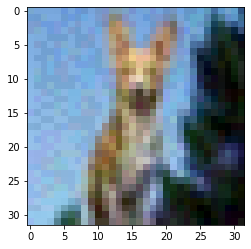

In [15]:
plt.imshow(adv_list[1000].astype('int32'))

In [16]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),metrics=['MeanSquaredError'])
autoencoder.fit(np.array(adv_list[:5300]),np.array(benign_list[:5300]),
                epochs=30,
                batch_size=32,
                shuffle=True)

Epoch 1/30
166/166 [==============================] - 2s 10ms/step - loss: 2337.4561 - mean_squared_error: 2337.4561
Epoch 2/30
166/166 [==============================] - 2s 9ms/step - loss: 659.1400 - mean_squared_error: 659.1400
Epoch 3/30
166/166 [==============================] - 2s 9ms/step - loss: 445.5350 - mean_squared_error: 445.5350
Epoch 4/30
166/166 [==============================] - 2s 9ms/step - loss: 359.3074 - mean_squared_error: 359.3074
Epoch 5/30
166/166 [==============================] - 2s 10ms/step - loss: 293.7645 - mean_squared_error: 293.7645
Epoch 6/30
166/166 [==============================] - 2s 10ms/step - loss: 282.2061 - mean_squared_error: 282.2061
Epoch 7/30
166/166 [==============================] - 2s 10ms/step - loss: 215.6293 - mean_squared_error: 215.6293
Epoch 8/30
166/166 [==============================] - 2s 9ms/step - loss: 196.4182 - mean_squared_error: 196.4182
Epoch 9/30
166/166 [==============================] - 2s 9ms/step - loss: 216.3603

W0128 18:05:35.482584 140584560478016 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0128 18:05:35.823351 140584560478016 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0128 18:05:36.461066 140584560478016 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


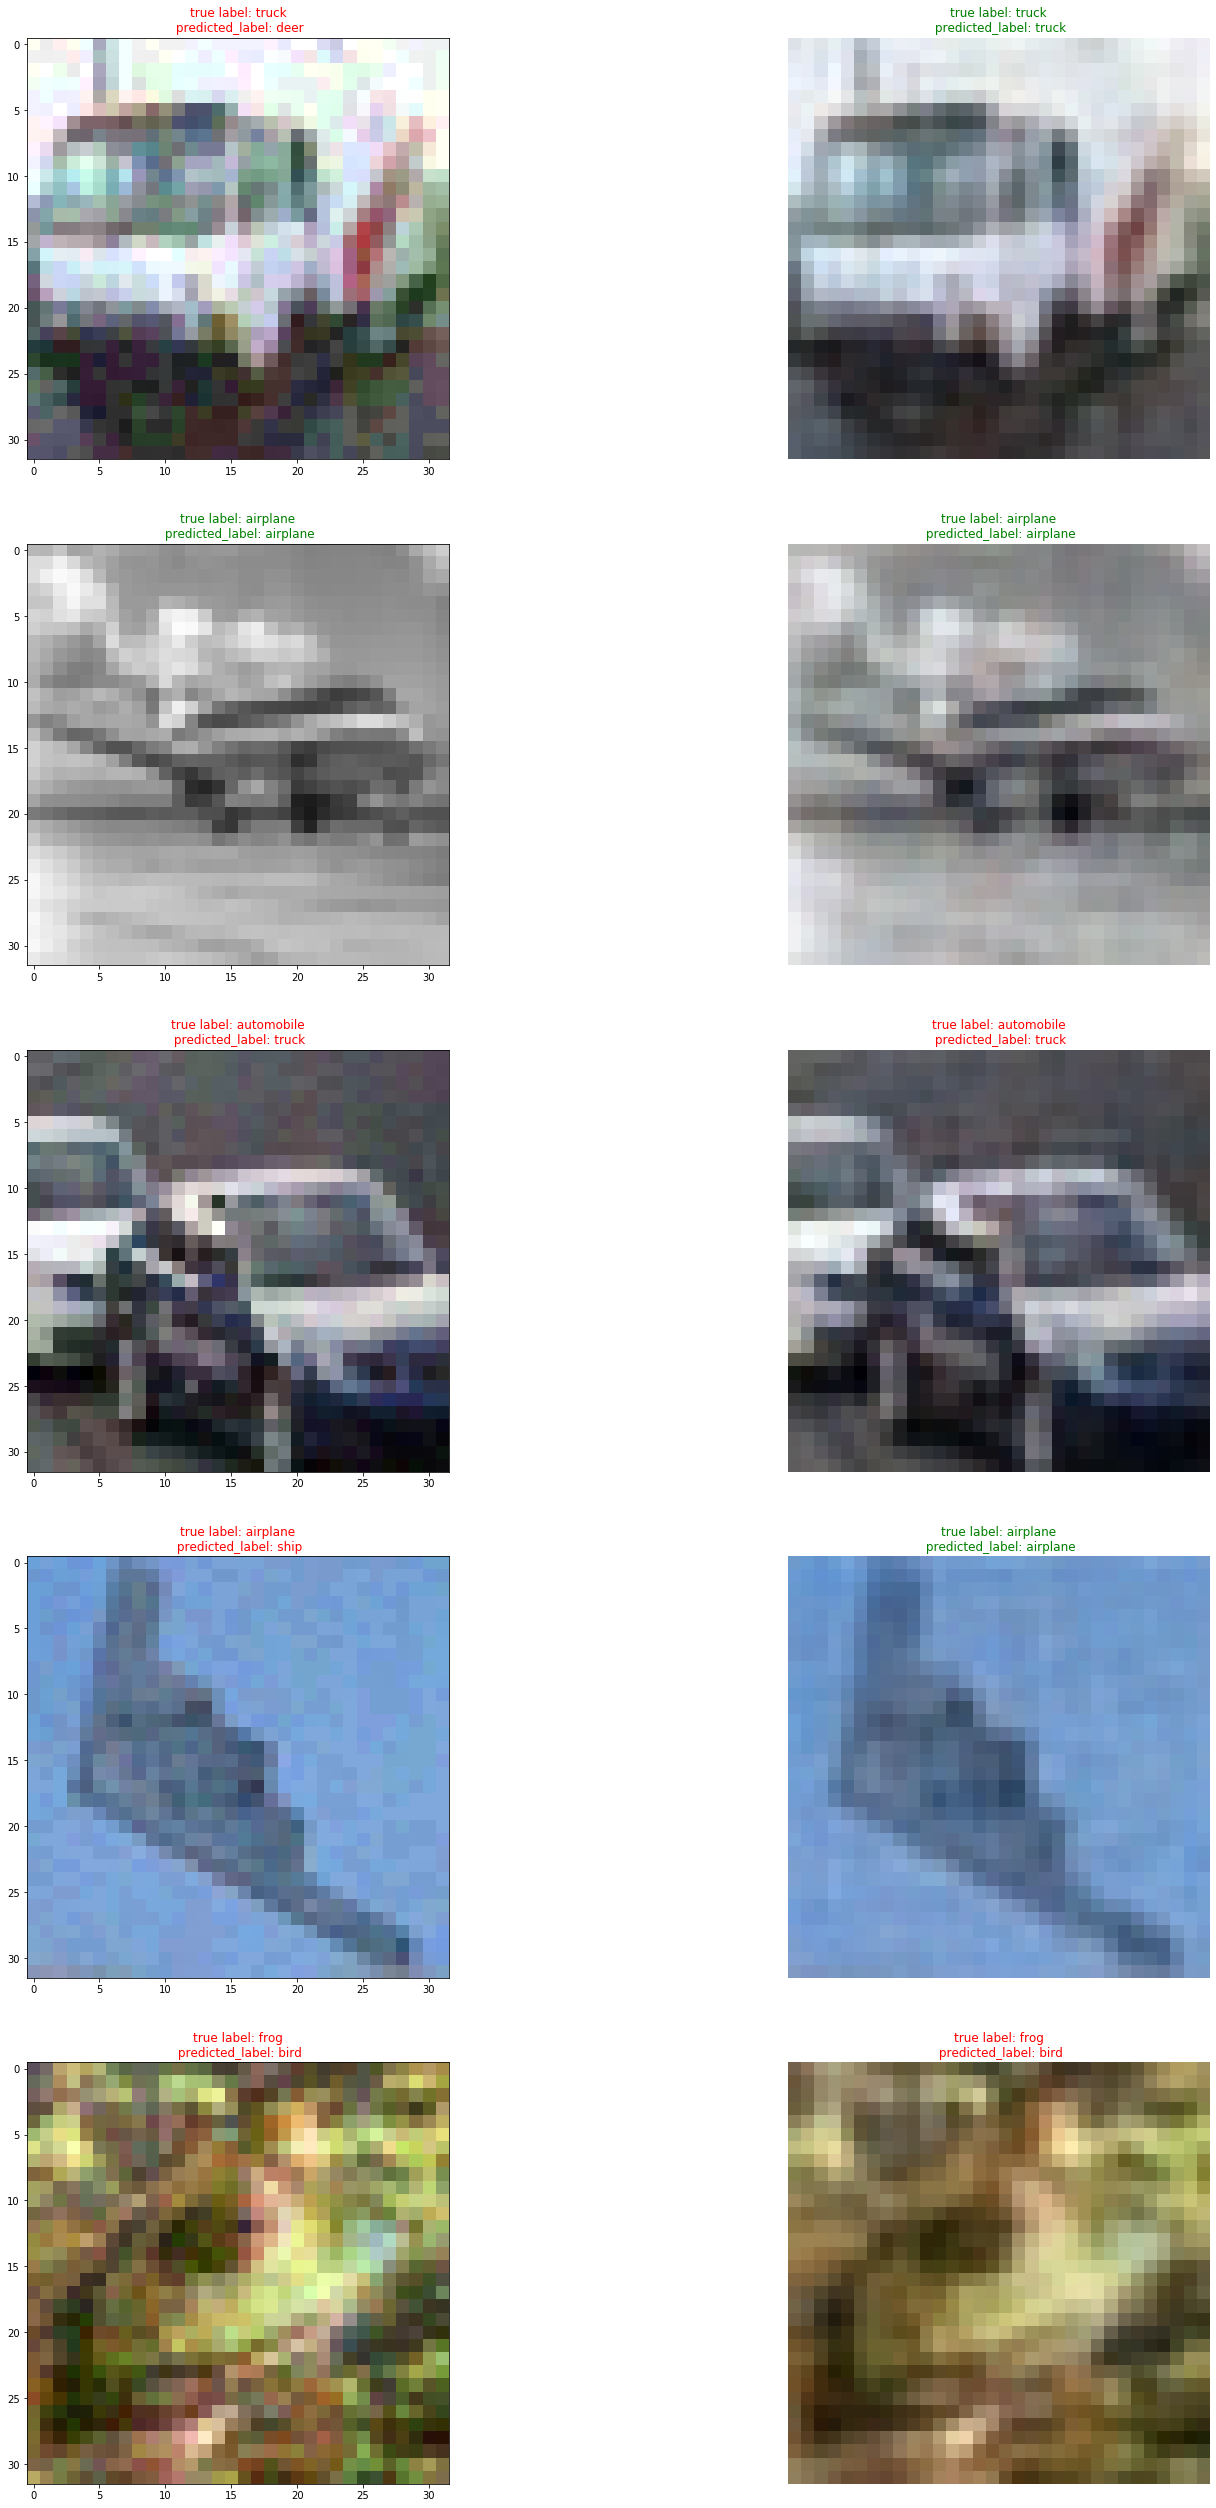

In [24]:
plt.figure(figsize=(25,45))
for i,(adv_image, true_label) in enumerate(zip(adv_list[3605:3610],adv_true_label[3605:3610])): 
   
    i=2*i
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(adv_image.astype('int32'))
    predicted_adv_label=dict_classes[np.argmax(model_effnet.predict(np.expand_dims(adv_image,axis=0)))]
    true_label=dict_classes[true_label]
    if true_label==predicted_adv_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_adv_label),color=color)
    
    ax = plt.subplot(5, 2, i + 2)
    new_image=autoencoder.predict(np.expand_dims(adv_image,axis=0))
    predicted_label=dict_classes[np.argmax(model_effnet.predict(new_image))]
    plt.imshow(np.squeeze(new_image).astype('int32'))
    if true_label==predicted_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label),color=color)
    plt.axis("off")
plt.show()

Let's add the denoiser on top of the effnet_model.
Beforehand we made the denoiser not trainable

In [18]:
autoencoder.trainable=False
inputs=Input(shape=(32,32,3))
x=autoencoder(inputs)
o=model_effnet(x)

model_with_defense=Model(inputs,[o])


model_with_defense.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )

### 5. Useful functions

Let's define the peformances metrics

In [19]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

### 6. Attack robusteness

##### White box attack

In [20]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=epsilon)
        success_on_attacked_model.append(bool(is_adv[0]))
        adv_list.append(np.array(clipped[0]))
        prediction=predicting_model.predict(np.expand_dims(clipped[0],axis=0))
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
            
        
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [21]:
def attack_runner(model_to_attack,predicting_model,image_list, labels_list, epislons_list):  
    
    attack_FGSM=LinfFastGradientAttack()
    SR_FGSM_dic={}  
    SR_FGSM_dic_with_defense={}
    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,SR_FGSM_with_defense=attack_performances_computer(model_to_attack,predicting_model,attack_FGSM, image_list, labels_list,[epsilon])      
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        SR_FGSM_dic_with_defense[DOC_FGSM]=SR_FGSM_with_defense   
    return(SR_FGSM_dic,SR_FGSM_dic_with_defense)

In [22]:
SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense=attack_runner(model_effnet,model_with_defense,X_test[7000:7100], y_test[7000:7100], [0.1,0.5,1,5,7,10,15,20,30,50])

  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


W0128 17:56:18.795750 140584560478016 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("input_3:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1, 32, 32, 3).
W0128 17:56:18.797099 140584560478016 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("input_2:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1, 32, 32, 3).
  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 7======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 15======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 20======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 30======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


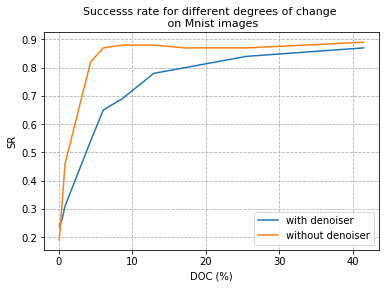

In [23]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with denoiser')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without denoiser')
# plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='lower right')